## Berechnung eines Steinschlags an der Kantonsstrasse in Fiersch (Kt. GR) 
   In der folgenden Berechnung wird anhand der Daten der letzten drei Monate die Wahrscheinlichkeit 
   berechnet für einen tödlichen Steinschlag und basierend auf den Erkentnissen der Berechnungen ob die Strassen gesperrt 
   werden muss oder nicht.
   Wird die Strasse gesperrt wird untersucht ob diese den ganzen Tag gesperrt bleibt oder nur für eine gewisse Zeit am Tag

### Annahmen:
1. Die Ablösungszonen 1 und 2 befinden sich an zwei verschiedenen Stellen
2. Die Steine aus den beiden Ablösungszonen werden mit dem gleichen Netz aufgefangen
3. Die Wahrscheinlichkeiten werden pro Stundenfenster berechnet und nicht pro Minute
4. Die Verteilung des Verkehrs basiert auf den Erkentnissen des Bundesamtes für Statistik

### Berechnungsmodel:
Um eine Simulations des Models zu bewerkstelligen müssen die einzelnen Variabeln und deren logische Abhängigkeiten 
in eine Reihenfolge gebracht werden. Aus dieser Betrachten sollte sich dann ein Model ergeben welches durch eine 
Monte Carlo Simulation berechnet werden kann:
1. P (kinetische Energie) = Wahrscheinlichkeit Geschwindigkeit des Stein  * Wahrscheinlich Masse des Steins
2. P (Anzahl Abschläge / 24 h) = 24 Stunden / Wahrscheinlichkeit des Zeitdeltas
3. P (Netz bricht mit einem Aufprall) = P (kinetische Energie > 1000 kJ)
4. P1 (Netz bricht über Zeit) = Wenn Summe Masse der Steine > 2000 kg, dann P (kinetische Energie > 500 kJ )
4. P2 (Netz bricht über Zeit) = Wenn Summe Masse der Steine < 2000 kg, dann P (kinetische Energie > 1000 kJ )
6. Summe (Auto im Zeitfenster) = Summe der Menge der Autos in den Zeitfenstern (Leerung + P (Zeitdelta)  
5, P (Auto wird getroffen) = Summe (Auto im Zeitfenster) / Total Autos

Das Zusammensetzen der einzelnen Wahrscheinlichkeiten wird in einer Monte Carlo Simulation durch Zufallsvariablen 
simuliert, 

# TBD Model zusammenstellen


In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.stats import norm
from scipy.stats import lognorm

## 1. Daten einlesen, säubern und in eine einheitliche Form bringen.

In [36]:
# Daten laden
raw_data_1 = pd.read_csv("out_1.csv")
raw_data_2 = pd.read_csv("out_2.csv")

In [37]:
# Überprüfen wie viele "NA" Werte noch vorhanden sind
raw_data_1.isna().sum()

Datum                    11
Uhrzeit                  11
Masse [kg]               11
Geschwindigkeit [m/s]    11
Unnamed: 4               79
                         ..
Unnamed: 72              79
Unnamed: 73              79
Unnamed: 74              79
Unnamed: 75              79
Unnamed: 76              79
Length: 77, dtype: int64

In [38]:
raw_data_2.isna().sum()

Date            3
Uhrzeit         3
m [kg]          3
v [m/s]         3
Unnamed: 4     35
Unnamed: 5     35
Unnamed: 6     35
Unnamed: 7     35
Unnamed: 8     35
Unnamed: 9     35
Unnamed: 10    35
Unnamed: 11    35
Unnamed: 12    35
Unnamed: 13    35
Unnamed: 14    35
Unnamed: 15    35
Unnamed: 16    35
Unnamed: 17    35
Unnamed: 18    35
Unnamed: 19    35
Unnamed: 20    35
Unnamed: 21    35
Unnamed: 22    35
Unnamed: 23    35
Unnamed: 24    35
Unnamed: 25    35
Unnamed: 26    35
Unnamed: 27    35
Unnamed: 28    35
Unnamed: 29    35
Unnamed: 30    35
dtype: int64

In [39]:
# Alle Zeilen löschen die in ALLEN Zellen keine Werte haben
data_1_no_rows = raw_data_1.dropna(how='all')
data_2_no_rows = raw_data_2.dropna(how='all')

# Alle Kolonen löschen die NA Werte enthalten
data_1_no_na = data_1_no_rows.dropna(axis= 'columns')
data_2_no_na = data_2_no_rows.dropna(axis= 'columns')

In [40]:
#Um eine Vergleichbarkeit von Daten herstellen zu können sollte die Benennung der Zellen die selbe sein
data_stelle_1= data_1_no_na.rename(columns= {'Datum':'Date',
                                             'Uhrzeit': 'Time',
                                             'Masse [kg]' : 'Masse in kg' ,
                                             'Geschwindigkeit [m/s]' : 'Speed in m/s' 
                                            })

In [41]:
data_stelle_2= data_2_no_na.rename(columns= {'Uhrzeit': 'Time',
                                             'm [kg]' : 'Masse in kg' ,
                                             'v [m/s]' : 'Speed in m/s' 
                                            })

In [42]:
# Überprüfen wie viele "NA" Werte noch vorhanden sind nachdem auch die Anpassung der Benennungen durchgeführt worden ist
data_stelle_1.isna().sum()

Date            0
Time            0
Masse in kg     0
Speed in m/s    0
dtype: int64

In [43]:
data_stelle_2.isna().sum()

Date            0
Time            0
Masse in kg     0
Speed in m/s    0
dtype: int64

In [44]:
# Zeit und Datum in eine Spalte bringen und in ein Datetime Object transformieren
data_stelle_1 ['Datetime'] = pd.to_datetime(data_stelle_1['Date'] + " " + data_stelle_1 ['Time'])
data_stelle_2 ['Datetime'] = pd.to_datetime(data_stelle_2['Date'] + " " + data_stelle_2 ['Time'])

In [45]:
# Die beiden Spalten 'Date' und 'Time' werden nicht mehr benötigt und werden gelöscht
data_stelle_1 = data_stelle_1.drop('Time', axis=1)
data_stelle_1 = data_stelle_1.drop('Date', axis=1)

data_stelle_2 = data_stelle_2.drop('Time', axis=1)
data_stelle_2 = data_stelle_2.drop('Date', axis=1)

In [46]:
# Datetime nach Zeit sortieren
data_stelle_2.sort_values(by= ['Datetime'])
data_stelle_1.sort_values(by= ['Datetime'])
   

,Masse in kg,Speed in m/s,Datetime
0,194.0,8.4,2019-01-01 09:00:00
1,224.0,8.8,2019-01-01 21:00:00
2,3104.0,9.2,2019-01-02 14:00:00
3,228.0,8.0,2019-01-04 15:00:00
4,755.0,7.0,2019-01-05 23:00:00
...,...,...,...
63,167.0,8.9,2019-03-18 16:00:00
64,2847.0,7.0,2019-03-22 18:00:00
65,44.0,8.9,2019-03-26 00:00:00
66,45.0,8.4,2019-03-26 06:00:00


## 2. Hinzufügen und Berechnung von fehlenden Daten

In [47]:
# Berechnung der Zeit zwischen den einzelnen Steinschlägen. 
# Die Anzahl Differenzen beläuft sich auf Anzahl Beobachtungen - 1

# Zeitdifferenzen Abschlagstelle 1
t_delta_stelle_1 = []
for x in range (len(data_stelle_1['Datetime'])):
    try:
        delta = int(abs(data_stelle_1 ['Datetime'] [x] - data_stelle_1 ['Datetime'] [x+1]).total_seconds() / 3600)
        t_delta_stelle_1.append(delta)   
    except:
        pass   

# Zeitdifferenzen Abschlagstelle 2
t_delta_stelle_2 = []
for x in range (len(data_stelle_2['Datetime'])):
    try:
        delta = int(abs(data_stelle_2 ['Datetime'] [x] - data_stelle_2 ['Datetime'] [x+1]).total_seconds() / 3600)
        t_delta_stelle_2.append(delta)   
    except:
        pass   
    
# Liste in Pandas DataFrame transformieren
t_delta_stelle_1 = pd.DataFrame(t_delta_stelle_1, columns = ['Delta'])
t_delta_stelle_2 = pd.DataFrame(t_delta_stelle_2, columns = ['Delta'])

In [69]:
#Verteilung des Verkehrs über die Zeit. Dafür werden die Daten des Bundesamts für Statstik herangezogen.
#Credit geht hier an Roman Studer, der die Daten vom Bundesamt für Statistik besorgt hat
traffic = pd.read_csv("traffic.csv")


,hour,percentile
0,0,1.507968
1,1,0.712208
2,2,0.456835
3,3,0.421837
4,4,0.980265
5,5,3.396247
6,6,9.222772
7,7,12.244562
8,8,11.129274
9,9,12.008594


## 3. Datenanalyse - Welche Verteilung liegt in den einzelnen Datensätzen vor?
Vorgehen: Zuerst werden Histogramme der einzelnen Variabeln erstellet und im zweiten Schritt ein QQ Plot.   
Um zu überprüfen welche Verteilung den vorhergegangenen Histogrammen zugrunde liegt, 
werden im nächsten Schritt QQ-Plots erstellt um eine visuelle Überprüfung einer Normalverteilung vorzunehmen.

#### Masse Ablösestelle 1

In [48]:
# Analyse 
data_stelle_1['Masse in kg'].describe()

count      68.000000
mean      628.632353
std       695.884703
min        12.000000
25%       214.750000
50%       402.500000
75%       773.000000
max      3104.000000
Name: Masse in kg, dtype: float64

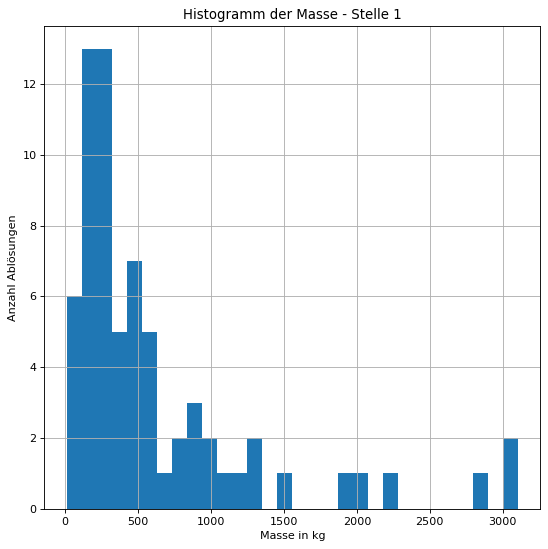

In [49]:
# Histogramm 
plt.figure(figsize=(8, 8), dpi=80)
plt.hist(data_stelle_1['Masse in kg'], bins = 30)

plt.title("Histogramm der Masse - Stelle 1")
plt.ylabel("Anzahl Ablösungen")
plt.xlabel("Masse in kg")   
plt.grid(True)
plt.show()

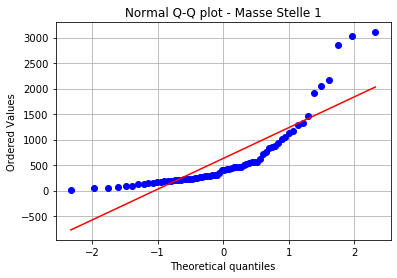

In [50]:
# QQ - Plot
stats.probplot(data_stelle_1['Masse in kg'], dist="norm", plot=plt)
plt.title("Normal Q-Q plot - Masse Stelle 1")
plt.grid(True)
plt.show()

#### Masse Ablösestelle 2

In [51]:
# Analyse
data_stelle_2['Masse in kg'].describe()

count     32.000000
mean      99.250000
std      104.072555
min        0.000000
25%       36.750000
50%       58.000000
75%      140.000000
max      406.000000
Name: Masse in kg, dtype: float64

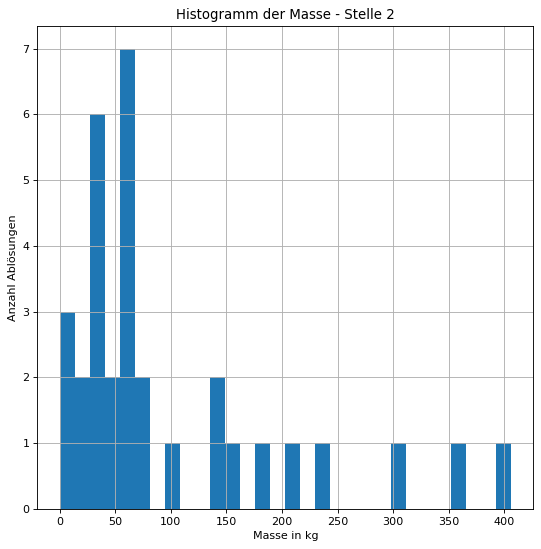

In [52]:
# Histogramm 
plt.figure(figsize=(8, 8), dpi=80)
plt.hist(data_stelle_2['Masse in kg'], bins = 30)

plt.title("Histogramm der Masse - Stelle 2")
plt.ylabel("Anzahl Ablösungen")
plt.xlabel("Masse in kg") 
plt.grid(True)
plt.show()

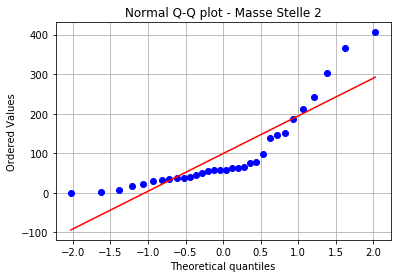

In [53]:
# QQ - Plot
stats.probplot(data_stelle_2['Masse in kg'], dist="norm", plot=plt)
plt.title("Normal Q-Q plot - Masse Stelle 2")
plt.grid(True)
plt.show()

#### Geschwindigkeit Ablösestelle 1

In [54]:
# Analyse
data_stelle_1['Speed in m/s'].describe()

count    68.000000
mean      8.788235
std       1.989189
min       3.600000
25%       7.300000
50%       8.800000
75%      10.125000
max      14.100000
Name: Speed in m/s, dtype: float64

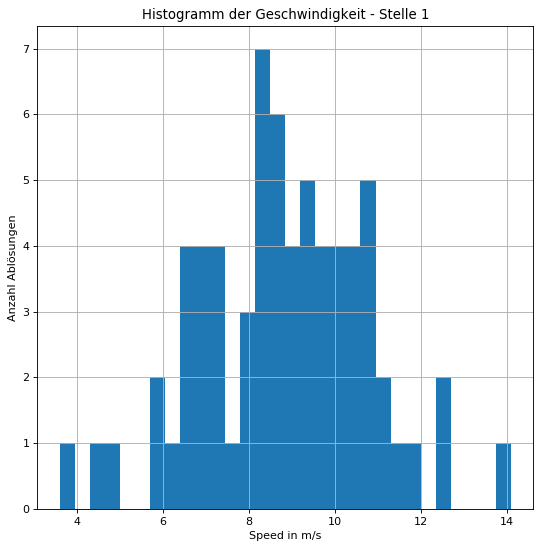

In [55]:
# Histogramm 
plt.figure(figsize=(8, 8), dpi=80)
plt.hist(data_stelle_1['Speed in m/s'], bins = 30)

plt.title("Histogramm der Geschwindigkeit - Stelle 1")
plt.ylabel("Anzahl Ablösungen")
plt.xlabel("Speed in m/s")   
plt.grid(True)
plt.show()

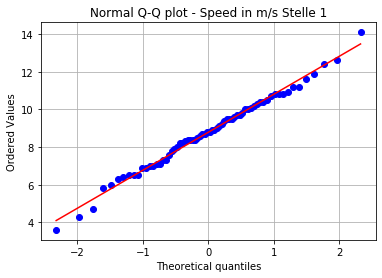

In [56]:
# QQ - Plot
stats.probplot(data_stelle_1['Speed in m/s'], dist="norm", plot=plt)
plt.title("Normal Q-Q plot - Speed in m/s Stelle 1")
plt.grid(True)
plt.show()

#### Geschwindigkeit Ablösestelle 2

In [57]:
# Analyse 
data_stelle_2['Speed in m/s'].describe()

count    32.000000
mean     37.790625
std       5.395778
min      24.900000
25%      33.200000
50%      38.750000
75%      41.725000
max      46.500000
Name: Speed in m/s, dtype: float64

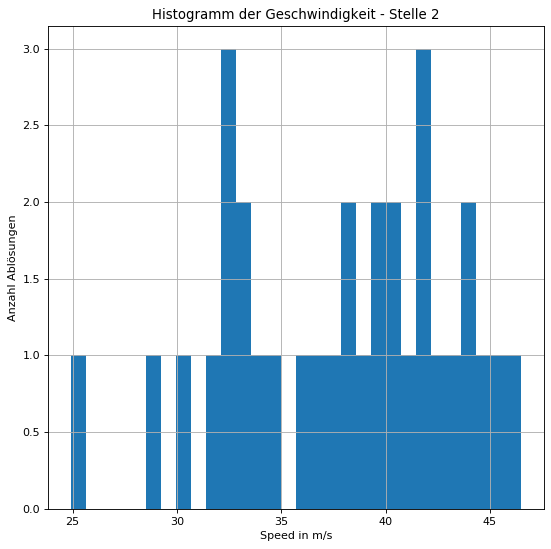

In [58]:
# Histogramm 
plt.figure(figsize=(8, 8), dpi=80)
plt.hist(data_stelle_2['Speed in m/s'], bins = 30)

plt.title("Histogramm der Geschwindigkeit - Stelle 2")
plt.ylabel("Anzahl Ablösungen")
plt.xlabel("Speed in m/s")
plt.grid(True)
plt.show()

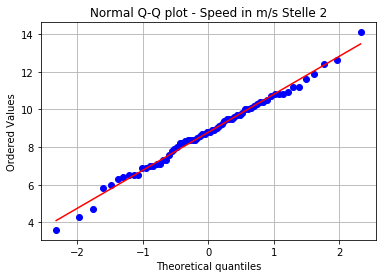

In [59]:
# QQ - Plot
stats.probplot(data_stelle_1['Speed in m/s'], dist="norm", plot=plt)
plt.title("Normal Q-Q plot - Speed in m/s Stelle 2")
plt.grid(True)
plt.show()

#### Zeitdifferenzen Ablösestelle 1

In [60]:
# Analyse 
t_delta_stelle_1.describe()

,Delta
count,67.000000
mean,30.552239
std,27.749029
min,0.000000
25%,6.000000
50%,22.000000
75%,49.000000
max,113.000000


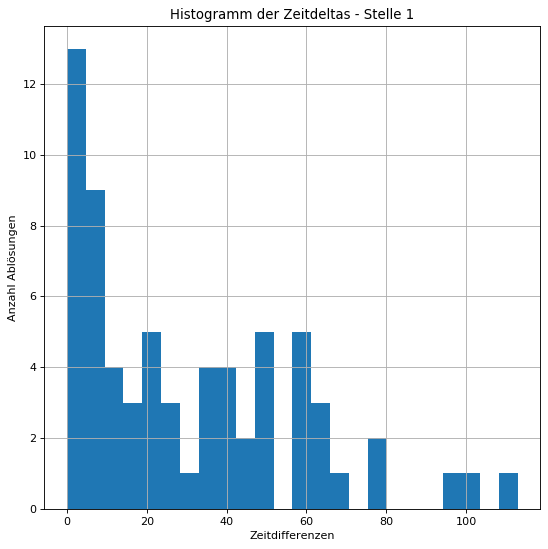

In [61]:
# Histogramm 
plt.figure(figsize=(8, 8), dpi=80)
plt.hist(t_delta_stelle_1 ['Delta'], bins = 24)

plt.title("Histogramm der Zeitdeltas - Stelle 1")
plt.ylabel("Anzahl Ablösungen")
plt.xlabel("Zeitdifferenzen")
plt.grid(True)
plt.show()

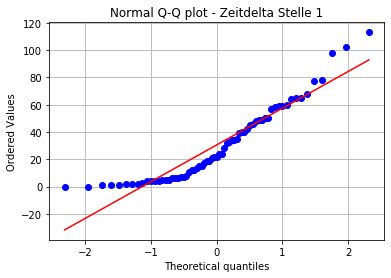

In [62]:
# QQ - Plot
stats.probplot(t_delta_stelle_1['Delta'], dist="norm", plot=plt)
plt.title("Normal Q-Q plot - Zeitdelta Stelle 1")
plt.grid(True)
plt.show()

#### Zeitdifferenzen Ablösestelle 2

In [63]:
# Analyse 
t_delta_stelle_2.describe()

,Delta
count,31.000000
mean,66.322581
std,55.178732
min,7.000000
25%,28.500000
50%,52.000000
75%,78.500000
max,212.000000


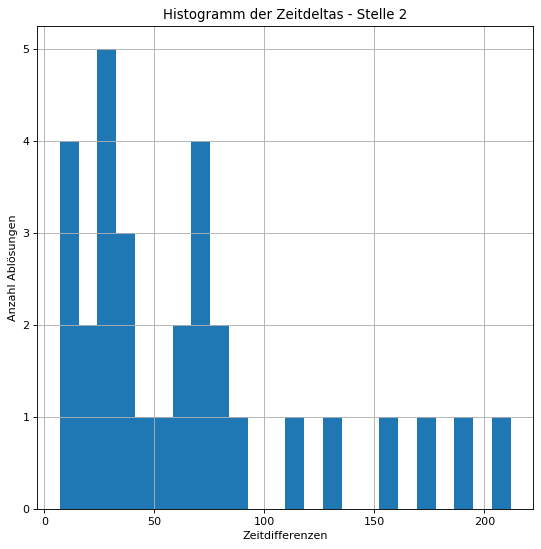

In [64]:
# Histogramm 
plt.figure(figsize=(8, 8), dpi=80)
plt.hist(t_delta_stelle_2 ['Delta'], bins = 24)

plt.title("Histogramm der Zeitdeltas - Stelle 2")
plt.ylabel("Anzahl Ablösungen")
plt.xlabel("Zeitdifferenzen")
plt.grid(True)
plt.show()

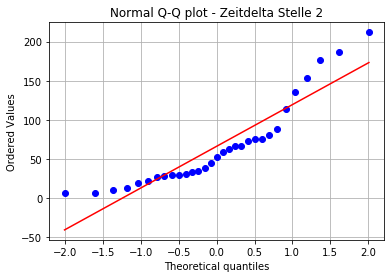

In [65]:
# QQ - Plot
stats.probplot(t_delta_stelle_2['Delta'], dist="norm", plot=plt)
plt.title("Normal Q-Q plot - Zeitdelta Stelle 2")
plt.grid(True)
plt.show()

## 3. Zufalsvariabeln definieren

1. P (kinetische Energie) = Wahrscheinlichkeit Geschwindigkeit des Stein  * Wahrscheinlich Masse des Steins
2. P (Anzahl Abschläge / 24 h) = 24 Stunden / Wahrscheinlichkeit des Zeitdeltas
3. P (Netz bricht mit einem Aufprall) = P (kinetische Energie > 1000 kJ)
4. P1 (Netz bricht über Zeit) = Wenn Summe Masse der Steine > 2000 kg, dann P (kinetische Energie > 500 kJ )
4. P2 (Netz bricht über Zeit) = Wenn Summe Masse der Steine < 2000 kg, dann P (kinetische Energie > 1000 kJ )
6. Summe (Auto im Zeitfenster) = Summe der Menge der Autos in den Zeitfenstern (Leerung + P (Zeitdelta)  
5, P (Auto wird getroffen) = Summe (Auto im Zeitfenster) / Total Autos

zufall_masse_stelle_1
zufall_masse_stelle_2

zufall_speed_stelle_1
zufall_masse_stelle_2

zufall_t_delta_stelle_1
zufall_t_delta_stelle_2


In [66]:
norm.pdf (200, 99.25, 104.07)




0.0023992249426286693